# IMPORTS

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import sys
import tensorflow as tf
import scipy.misc
import cv2
import os
import re
import imageio

# TESTING RESIZING

In [2]:
IMAGE_SZ = 128

def resize(in_PATH, out_PATH):
    img = Image.open(in_PATH).convert('RGB')
    img_scale = img.resize((IMAGE_SZ, IMAGE_SZ), Image.ANTIALIAS)
    plt.imshow(img_scale)
    img_scale.save(out_PATH, format='PNG')

def mask(in_PATH, out_PATH):
    img = np.array(Image.open(in_PATH).convert('RGB'))
    pix_avg = np.mean(img)
    img[:, :int(2 * IMAGE_SZ / 8), :] = img[:, int(-2 * IMAGE_SZ / 8):, :] = pix_avg
    img[:int(2 * IMAGE_SZ / 8),:, :] = img[int(-2 * IMAGE_SZ / 8):, :, :] = pix_avg
    img = Image.fromarray(img.astype(np.uint8), 'RGB')
    plt.imshow(img)
    img.save(out_PATH, format='PNG')

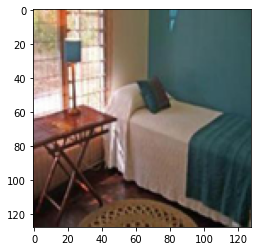

In [3]:
resize("data/val_256/val_256/Places365_val_00000671.jpg", "1.png")

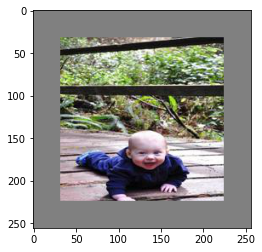

In [4]:
mask("data/val_256/val_256/Places365_val_00000001.jpg", "2.png")

# MODELS

### GENERATOR

In [5]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Flatten
def generator(): 
    model = tf.keras.Sequential() 
    model.add(Conv2D(64,kernel_size=[5, 5],strides = (1, 1),padding = 'same', kernel_initializer = "he_normal"))
    model.add(layers.ReLU())
    model.add(Conv2DTranspose(128, [3, 3], strides = (2 ,2),padding = 'same', kernel_initializer = "he_normal"))
    model.add(layers.ReLU())
    model.add(Conv2DTranspose(256, [3, 3], strides = (1, 1),dilation_rate=(2, 2) ,padding = 'same', kernel_initializer = "he_normal"))
    model.add(layers.ReLU())
    model.add(Conv2D(256, [3, 3], strides = (1, 1),dilation_rate=(4, 4) ,padding = 'same', kernel_initializer = "he_normal"))
    model.add(layers.ReLU())
    model.add(Conv2D(256, [3, 3], strides = (1, 1),dilation_rate=(8, 8) ,padding = 'same', kernel_initializer = "he_normal"))
    model.add(layers.ReLU())
    model.add(Conv2D(256, [3, 3], strides=(1, 1), padding="same"))
    model.add(layers.ReLU())
    model.add(Conv2D(128, [4, 4], strides=(2, 2), padding="same"))
    model.add(layers.ReLU())
    model.add(Conv2D(64, [3, 3], strides=(1, 1), padding="same"))
    model.add(layers.ReLU())
    model.add(Conv2D(3, [3, 3], strides=(1, 1), padding="same", activation="sigmoid"))
    model.build((None, 256, 256, 4))
    return model

### DISCRIMINATORS

In [6]:
def global_discriminator():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Flatten())
  model.add(Dense(units=512, activation=tf.nn.relu))
  
  model.build((None, 256, 256, 3))
  return model

In [7]:
def local_discriminator(shape):
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=[5, 5], strides=(2, 2), padding="same", activation='relu'))
  model.add(Flatten())
  model.add(Dense(units=512, activation=tf.nn.relu))
  
  model.build(shape)
  return model

In [8]:
def concatenator():
  model = Sequential()
  model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
  model.build((None, 2560))
  return model

# LOAD IMAGES

In [9]:
def load_images(PATH, start, end, verbose=False):
    imgs = []
    for filename in sorted(os.listdir(PATH)[start:end]):
        if verbose:
            print('Processing %s' % filename)
        full_filename = os.path.join(os.path.abspath(PATH), filename)
        img = Image.open(full_filename).convert('RGB')
        pix = np.array(img)
        pix_norm = pix / 255.0
        imgs.append(pix_norm)
    return np.array(imgs)

In [10]:
def compileImages(PATH):
  prev = 0
  for i in range(500, 15000, 500):
    imgs = load_images(PATH, prev, i, verbose=False)
    np.save("output/TrainData/TrainData" + str(prev) + "-" + str(i), imgs)
    prev = i
    print(prev, end = " ")
compileImages("data/val_256/val_256")

In [11]:
imgs = load_images("data/val_256/val_256", 36000, 36004, verbose=False)
np.save("output/TestData/TestData", imgs)

## PRE-PROCESS IMAGES

In [12]:
def preprocess_images_outpainting(imgs, crop=True):
    m = imgs.shape[0]
    imgs = np.array(imgs, copy=True)
    pix_avg = np.mean(imgs, axis=(1, 2, 3))
    if crop:
        imgs[:, :, :int(2 * IMAGE_SZ / 8), :] = imgs[:, :, int(-2 * IMAGE_SZ / 8):, :] = pix_avg[:, np.newaxis, np.newaxis, np.newaxis]
        imgs[:, :int(2 * IMAGE_SZ / 8), :, :] = imgs[:, int(-2 * IMAGE_SZ / 8):, :, :] = pix_avg[:, np.newaxis, np.newaxis, np.newaxis]
    mask = np.zeros((m, 256, 256, 1))
    mask[:, :, :int(2 * IMAGE_SZ / 8), :] = mask[:, :, int(-2 * IMAGE_SZ / 8):, :] = 1.0
    mask[:, :int(2 * IMAGE_SZ / 8), :, :] = mask[:, int(-2 * IMAGE_SZ / 8):, :, :] = 1.0
    imgs_p = np.concatenate((imgs, mask), axis=3)
    return imgs_p

In [13]:
import glob
npfiles = glob.glob("output/TrainData/*.npy")
npfiles.sort()
imgs = np.load(os.path.join("output/TrainData", npfiles[0]))
imgs_p = preprocess_images_outpainting(np.load(os.path.join("output/TrainData", npfiles[0])))
for npfile in npfiles[1:20]:
    img = np.load(os.path.join("output/TrainData", npfile))
    img_p = preprocess_images_outpainting(img)
    imgs_p = np.concatenate([imgs_p, img_p], axis = 0)
    imgs = np.concatenate([imgs, img], axis = 0)
    print(npfile + " DONE", imgs_p.shape, imgs.shape)


/content/TrainData/TrainData1000-1500.npy DONE (1000, 256, 256, 4) (1000, 256, 256, 3)
/content/TrainData/TrainData10000-10500.npy DONE (1500, 256, 256, 4) (1500, 256, 256, 3)
/content/TrainData/TrainData10500-11000.npy DONE (2000, 256, 256, 4) (2000, 256, 256, 3)
/content/TrainData/TrainData11000-11500.npy DONE (2500, 256, 256, 4) (2500, 256, 256, 3)
/content/TrainData/TrainData11500-12000.npy DONE (3000, 256, 256, 4) (3000, 256, 256, 3)
/content/TrainData/TrainData12000-12500.npy DONE (3500, 256, 256, 4) (3500, 256, 256, 3)
/content/TrainData/TrainData12500-13000.npy DONE (4000, 256, 256, 4) (4000, 256, 256, 3)
/content/TrainData/TrainData13000-13500.npy DONE (4500, 256, 256, 4) (4500, 256, 256, 3)
/content/TrainData/TrainData13500-14000.npy DONE (5000, 256, 256, 4) (5000, 256, 256, 3)
/content/TrainData/TrainData14000-14500.npy DONE (5500, 256, 256, 4) (5500, 256, 256, 3)
/content/TrainData/TrainData1500-2000.npy DONE (6000, 256, 256, 4) (6000, 256, 256, 3)
/content/TrainData/TrainD

In [14]:
def norm_image(img_r):
    img_norm = tf.math.multiply(img_r, 255)
    img_norm = tf.cast(img_norm, dtype=tf.uint8)
    return img_norm

def save_image(img_r, name, mode='RGB'):
    img_norm = norm_image(img_r)
    tf.keras.utils.save_img(name, img_norm)

In [15]:
test_img = np.load("output/TestData/TestData.npy")
test_img_p = preprocess_images_outpainting(test_img)

train_img = imgs[4, np.newaxis]
train_img_p = imgs_p[4, np.newaxis]

In [16]:
test_img_p.shape

(4, 256, 256, 4)

## HYPERPARAMETERS

In [17]:
BATCH_SZ = 4
VERBOSE = False
EPSILON = 1e-9
IMAGE_SZ = 128
OUT_DIR = 'output'
MODEL_DIR = os.path.join(OUT_DIR, 'models')
INFO_PATH = os.path.join(OUT_DIR, 'run.txt')
N_TEST = 4

# FOR TRAINING
# N_ITERS = 80000
# N_ITERS_P1 = 30000
# N_ITERS_P2 = 6000
# INTV_PRINT = 1000

# FOR FAST TRAINING
N_ITERS = 10000
N_ITERS_P1 = 3000
N_ITERS_P2 = 600
INTV_PRINT = 1000
INTV_SAVE = 50
ALPHA = 0.0004

In [18]:
# import os
 
# dir = '/content/testoutput'
# for f in os.listdir(dir):
#   if(f[-4:] == ".png"):
#     os.remove(os.path.join(dir, f))

In [19]:
start_iter = 0
model_filename = None

In [20]:
save_image(train_img[0], os.path.join(OUT_DIR, 'train_img.png'))
for i_test in range(N_TEST):
    save_image(test_img[i_test], os.path.join(OUT_DIR, 'test_img_%d.png' % i_test))

In [21]:
mse = tf.keras.losses.MeanSquaredError()

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_mse_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## LOSSES

In [23]:
from tensorflow.python.ops.logging_ops import ImageSummary
def discriminator_loss(C_real, C_fake):
  return -tf.math.reduce_mean(tf.math.log(tf.math.maximum(C_real, EPSILON)) + tf.math.log(tf.math.maximum(1. - C_fake, EPSILON)))
  
def generator_mse_loss(real_output, fake_output):
    return mse(real_output, fake_output)

def generator_loss(G_MSE_loss, C_fake):
  return G_MSE_loss - tf.cast(ALPHA * tf.math.reduce_mean(tf.math.log(tf.math.maximum(C_fake, EPSILON))), dtype = tf.float64)

In [24]:
train_MSE_loss = []
dev_MSE_loss = []

last_output_PATH = [None] * N_TEST

In [25]:
def sample_random_minibatch(data, data_p, m):
    indices = np.random.randint(0, data.shape[0], m)
    return data[indices], data_p[indices]

In [26]:
gen = generator()
global_d = global_discriminator()
local_left = local_discriminator((None, 256, 64, 3))
local_right = local_discriminator((None, 256, 64, 3))
local_top = local_discriminator((None, 64, 256, 3))
local_bottom = local_discriminator((None, 64, 256, 3))

In [27]:
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      6464      
                                                                 
 re_lu (ReLU)                (None, 256, 256, 64)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 512, 512, 128)    73856     
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 512, 512, 128)     0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 512, 512, 256)    295168    
 ranspose)                                                       
                                                                 
 re_lu_2 (ReLU)              (None, 512, 512, 256)     0

In [28]:
c = concatenator()

In [29]:
VERBOSE = False

# TRAINING 

### TRAIN STEP

In [30]:
# @tf.function
def train_step(images, i, noise):
    gen_loss, disc_loss, gen_mse_loss = None, None, None
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as gen_mse_tape:
      generated_images = gen(noise, training=True)
      if(i < N_ITERS_P1):
        if(i == 0):
          print("---- ----Starting Phase 1--------")
        # print(generated_images.shape)
        gen_mse_loss = generator_mse_loss(generated_images, images)
        gradients_of_generator = gen_mse_tape.gradient(gen_mse_loss, gen.trainable_variables)
        generator_mse_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

      elif(i < N_ITERS_P1 + N_ITERS_P2):
        if(i == N_ITERS_P1):
          print('---- ----Starting Phase 2--------')
          print(images[:, :, : IMAGE_SZ//2, :].shape)

        
        g_e_r = global_d(images)
        l_r_r = local_right(images[:, :, : IMAGE_SZ//2, :])
        l_l_r = local_left(images[:, :, - IMAGE_SZ // 2:, :])
        l_t_r = local_top(images[:, :IMAGE_SZ // 2, :, :])
        l_b_r = local_bottom(images[:, -IMAGE_SZ // 2: ,: ,:])

        c_real = c(tf.concat([g_e_r, l_l_r, l_r_r, l_t_r, l_b_r], axis = 1))

        g_e_f = global_d(generated_images)
        l_r_f = local_right(generated_images[:, :, : IMAGE_SZ//2, :])
        l_l_f = local_left(generated_images[:, :, -IMAGE_SZ // 2:, :])
        l_t_f = local_top(generated_images[:, :IMAGE_SZ // 2, :, :])
        l_b_f = local_bottom(generated_images[:, -IMAGE_SZ // 2: ,:, :])
        c_fake = c(tf.concat([g_e_f, l_l_f, l_r_f, l_t_f, l_b_f], axis = 1))
        disc_loss = discriminator_loss(c_real, c_fake)
        var_c = global_d.trainable_variables + local_left.trainable_variables + local_right.trainable_variables + local_top.trainable_variables + local_bottom.trainable_variables +  c.trainable_variables 
        gradients_of_discriminator = disc_tape.gradient(disc_loss, var_c)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, var_c))
        if(VERBOSE):
          print((i, disc_loss, np.min(c_real), np.max(c_real), np.min(c_fake), np.max(c_fake)))
      else:
        if i == N_ITERS_P1 + N_ITERS_P2:
          print('---- ----Starting Phase 3--------')
        g_e_r = global_d(images)
        l_r_r = local_right(images[:, :, : IMAGE_SZ//2, :])
        l_l_r = local_left(images[:, :, -IMAGE_SZ // 2:, :])
        l_t_r = local_top(images[:, :IMAGE_SZ // 2, :, :])
        l_b_r = local_bottom(images[:, -IMAGE_SZ // 2: ,: ,:])
        c_real = c(tf.concat([g_e_r, l_l_r, l_r_r, l_t_r, l_b_r], axis = 1))

        g_e_f = global_d(generated_images)
        l_r_f = local_right(generated_images[:, :, : IMAGE_SZ//2, :])
        l_l_f = local_left(generated_images[:, :, -IMAGE_SZ // 2:, :])
        l_t_f = local_top(generated_images[:, :IMAGE_SZ // 2, :, :])
        l_b_f = local_bottom(generated_images[:, -IMAGE_SZ // 2: ,: ,:])
        c_fake = c(tf.concat([g_e_f, l_l_f, l_r_f, l_t_f, l_b_f], axis = 1))
        disc_loss = discriminator_loss(c_real, c_fake)
        var_c = global_d.trainable_variables + local_left.trainable_variables + local_right.trainable_variables + local_top.trainable_variables + local_bottom.trainable_variables +  c.trainable_variables 
        gradients_of_discriminator = disc_tape.gradient(disc_loss, var_c)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, var_c))
        if(VERBOSE):
          print((i, disc_loss, 'C', np.min(c_real), np.max(c_real), np.min(c_fake), np.max(c_fake)))

        gen_mse_loss = generator_mse_loss(generated_images, images)
        gen_loss = generator_loss(gen_mse_loss, c_fake)
        gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
        if VERBOSE:
          print((i, gen_loss, 'G', np.min(c_fake), np.max(c_fake)))


      G_MSE_loss_curr_dev = None
      if((i % INTV_PRINT) == 0):
        if generated_images is not None:
          output = gen(test_img_p)
          G_MSE_loss_curr_dev = generator_mse_loss(output, test_img)
          for i_test in range(N_TEST):
            save_image(output[i_test], os.path.join(OUT_DIR, 'dev_%d_%d.png' % (i_test, i)))
            last_output_PATH[i_test] = os.path.join(OUT_DIR, 'dev_%d_%d.png' % (i_test, i))

          print('Iteration [%d/%d]:' % (i, N_ITERS))
          if gen_mse_loss is not None:
              print('\tG_MSE_loss (train) = %f' % gen_mse_loss)
          if G_MSE_loss_curr_dev is not None:
              print('\tG_MSE_loss (dev) = %f' % G_MSE_loss_curr_dev)
          if gen_loss is not None:
              print('\tG_loss = %f' % gen_loss)
          if disc_loss is not None:
              print('\tC_loss = %f' % disc_loss)

        # Keep track of losses for logging
        if gen_mse_loss is not None:
            train_MSE_loss.append([i, gen_mse_loss])
        if G_MSE_loss_curr_dev is not None:
            dev_MSE_loss.append([i, G_MSE_loss_curr_dev])

In [31]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [32]:
test_img_p.shape

(4, 256, 256, 4)

### TRAINING

In [33]:
for i in range(start_iter, N_ITERS + 1):
  batch, batch_p = sample_random_minibatch(imgs, imgs_p, BATCH_SZ)
  train_step(batch, i, batch_p)

---- ----Starting Phase 1--------
Iteration [0/80000]:
	G_MSE_loss (train) = 0.092981
	G_MSE_loss (dev) = 0.073816
Iteration [1000/80000]:
	G_MSE_loss (train) = 0.021913
	G_MSE_loss (dev) = 0.024614
Iteration [2000/80000]:
	G_MSE_loss (train) = 0.014861
	G_MSE_loss (dev) = 0.023275
Iteration [3000/80000]:
	G_MSE_loss (train) = 0.022419
	G_MSE_loss (dev) = 0.022714
Iteration [4000/80000]:
	G_MSE_loss (train) = 0.025534
	G_MSE_loss (dev) = 0.022063
Iteration [5000/80000]:
	G_MSE_loss (train) = 0.019046
	G_MSE_loss (dev) = 0.022073
Iteration [6000/80000]:
	G_MSE_loss (train) = 0.016487
	G_MSE_loss (dev) = 0.021531
Iteration [7000/80000]:
	G_MSE_loss (train) = 0.019538
	G_MSE_loss (dev) = 0.021161
Iteration [8000/80000]:
	G_MSE_loss (train) = 0.016425
	G_MSE_loss (dev) = 0.021207
Iteration [9000/80000]:
	G_MSE_loss (train) = 0.021792
	G_MSE_loss (dev) = 0.021684
Iteration [10000/80000]:
	G_MSE_loss (train) = 0.020637
	G_MSE_loss (dev) = 0.021040
Iteration [11000/80000]:
	G_MSE_loss (train)

In [34]:
np.savez(os.path.join(OUT_DIR, 'loss.npz'), train_MSE_loss=np.array(train_MSE_loss), dev_MSE_loss=np.array(dev_MSE_loss))

In [ ]:
# !zip -r "/content/output.zip" "/content/output"

In [ ]:
# from google.colab import files
# files.download("/content/output.zip")

# PLOTS

### TRAINING LOSS PLOT

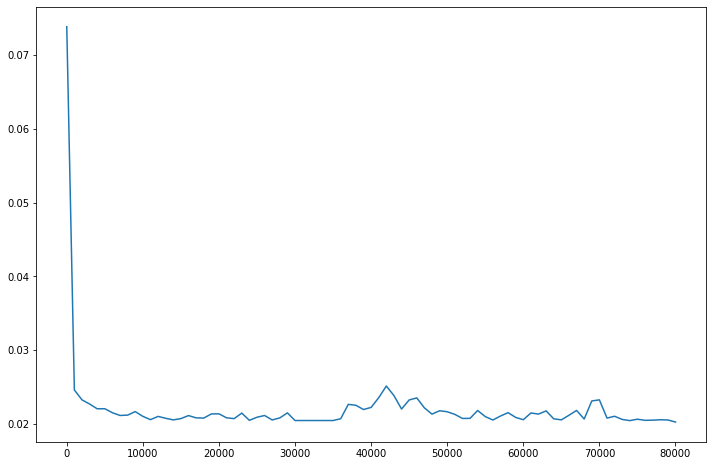

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
iteration = []
mse = []
for i in dev_MSE_loss:
  iteration.append(i[0])
  mse.append(i[1].numpy())

fig=plt.figure(figsize=(12,8))
plt.plot(iteration, mse)
plt.show()

### VALIDATION LOSS PLOT

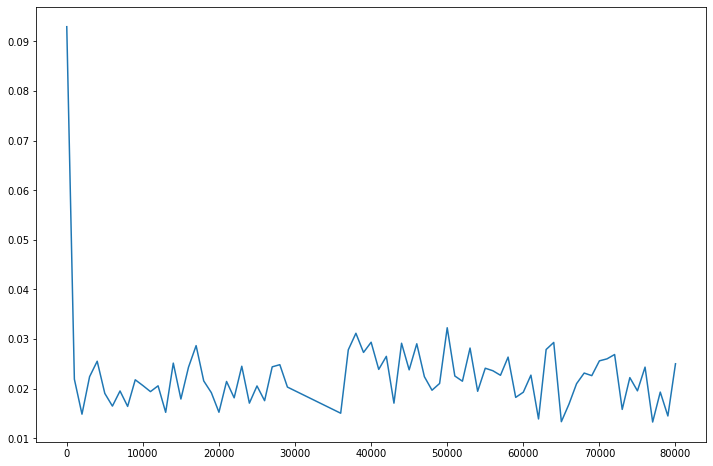

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
iteration = []
mse = []
for i in train_MSE_loss:
  iteration.append(i[0])
  mse.append(i[1].numpy())

fig=plt.figure(figsize=(12,8))
plt.plot(iteration, mse)
plt.show()

In [42]:
output = gen(test_img_p)
output = output.numpy()
count = 0
for i in output:
  i = i * 255
  i = np.array(i, dtype = np.uint8)
  img = Image.fromarray(i, mode = 'RGB')
  count += 1
  img.save('/content/testoutput/' + str(count) + '.png', format='PNG')

In [43]:
!zip -r "/content/testoutput.zip" "/content/testoutput"
files.download("/content/testoutput.zip")

  adding: content/testoutput/ (stored 0%)
  adding: content/testoutput/4.png (deflated 0%)
  adding: content/testoutput/3.png (deflated 0%)
  adding: content/testoutput/1.png (deflated 0%)
  adding: content/testoutput/2.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
def postprocess_images_outpainting(img_PATH, img_o_PATH, out_PATH, blend=False):
    src = cv2.imread(img_PATH)[int(2 * IMAGE_SZ / 8):-int(2 * IMAGE_SZ / 8), int(2 * IMAGE_SZ / 8):-int(2 * IMAGE_SZ / 8), :]
    dst = cv2.imread(img_o_PATH)
    if blend:
        mask = np.ones(src.shape, src.dtype) * 255
        center = (int(IMAGE_SZ) - 1, int(IMAGE_SZ) - 1)
        print(src.shape, dst.shape, mask.shape,center)
        out = cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)
    else:
        out = dst.copy()
        out[int(2 * IMAGE_SZ / 8):-int(2 * IMAGE_SZ / 8), int(2 * IMAGE_SZ / 8):-int(2 * IMAGE_SZ / 8), :] = src
    cv2.imwrite(out_PATH, out)

In [65]:
for i_test in range(N_TEST):
    postprocess_images_outpainting(os.path.join(OUT_DIR, 'test_img_%d.png' % i_test), last_output_PATH[i_test], os.path.join(OUT_DIR, 'out_paste_%d.png' % i_test), blend=False)
    postprocess_images_outpainting(os.path.join(OUT_DIR, 'test_img_%d.png' % i_test), last_output_PATH[i_test], os.path.join(OUT_DIR, 'out_blend_%d.png' % i_test), blend=True)

(192, 192, 3) (256, 256, 3) (192, 192, 3) (127, 127)
(192, 192, 3) (256, 256, 3) (192, 192, 3) (127, 127)
(192, 192, 3) (256, 256, 3) (192, 192, 3) (127, 127)
(192, 192, 3) (256, 256, 3) (192, 192, 3) (127, 127)
